In [18]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score
import seaborn as sns

### `Imports + Paths + Load Splits`

In [5]:
# Fix CWD (prevents the earlier os.getcwd() error)
PROJECT_ROOT = Path.home() / "Documents" / "rice_project"
os.chdir(PROJECT_ROOT)
print("CWD:", os.getcwd())

# Reproducibility (journal-friendly)
SEED = 20260115
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Paths
SPLITS_DIR = PROJECT_ROOT / "data" / "splits"
train_df = pd.read_csv(SPLITS_DIR / "train.csv")
val_df   = pd.read_csv(SPLITS_DIR / "val.csv")
test_df  = pd.read_csv(SPLITS_DIR / "test.csv")

print("Rows:", {"train": len(train_df), "val": len(val_df), "test": len(test_df)})

# Stable label mapping
classes = sorted(train_df["label"].unique().tolist())
label_to_id = {name: i for i, name in enumerate(classes)}
id_to_label = {i: name for name, i in label_to_id.items()}

train_df["label_id"] = train_df["label"].map(label_to_id)
val_df["label_id"]   = val_df["label"].map(label_to_id)
test_df["label_id"]  = test_df["label"].map(label_to_id)

print("Num classes:", len(classes), "| label_id range:", int(train_df.label_id.min()), "to", int(train_df.label_id.max()))
print("GPU:", tf.config.list_physical_devices("GPU"))

CWD: /home/arijit/Documents/rice_project
Rows: {'train': 11400, 'val': 3800, 'test': 3800}
Num classes: 38 | label_id range: 0 to 37
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Data pipeline `(CSV → tf.data)`

In [6]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ImageNet normalization
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD  = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def decode_resize_normalize(path, label_id):
    full_path = tf.strings.join([str(PROJECT_ROOT) + "/", path])
    img_bytes = tf.io.read_file(full_path)

    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)

    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    return img, label_id

# Mild, realistic training augmentation (journal-safe)
def augment(img, label_id):
    # flip is ok: rice appearance should be invariant to horizontal flips in most setups
    img = tf.image.random_flip_left_right(img, seed=SEED)
    # small brightness jitter (very mild)
    img = tf.image.random_brightness(img, max_delta=0.10, seed=SEED)
    return img, label_id

def make_dataset(df, training=False):
    paths = df["filepath"].astype(str).values
    labels = df["label_id"].astype(int).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(df), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(decode_resize_normalize, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_df, training=True)
val_ds   = make_dataset(val_df, training=False)
test_ds  = make_dataset(test_df, training=False)

print("✅ Datasets ready:", train_ds, val_ds, test_ds)


I0000 00:00:1768424587.130697   21059 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1235 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


✅ Datasets ready: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


### Build + compile baseline ResNet50 (frozen)
### Model definition `(ResNet50 backbone + small head)`

In [8]:
NUM_CLASSES = 38

# Backbone (pretrained on ImageNet)
base_model = keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling=None
)
base_model.trainable = False  # IMPORTANT: freeze for baseline stability

# Classifier head (simple, journal-safe)
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # mild regularization
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        77,862 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,665,574 (90.28 MB)

 Trainable params: 77,862 (304.15 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc")
    ],
)

print("✅ Model compiled.")

✅ Model compiled.


### Callbacks + training run

In [11]:
EXP_DIR = PROJECT_ROOT / "experiments" / "exp001_baseline_resnet50"
EXP_DIR.mkdir(parents=True, exist_ok=True)

checkpoint_path = EXP_DIR / "best_model.keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=str(checkpoint_path),
        monitor="val_acc",
        mode="max",
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_acc",
        mode="max",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.CSVLogger(
        filename=str(EXP_DIR / "train_log.csv"),
        append=False
    ),
]

EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("✅ Training finished. Best model saved to:", checkpoint_path)

Epoch 1/20
  2/357 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - acc: 0.0000e+00 - loss: 4.3559

I0000 00:00:1768424945.040602   21222 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


357/357 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - acc: 0.0563 - loss: 3.7433
Epoch 1: val_acc improved from None to 0.19500, saving model to /home/arijit/Documents/rice_project/experiments/exp001_baseline_resnet50/best_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 68s 166ms/step - acc: 0.0833 - loss: 3.4730 - val_acc: 0.1950 - val_loss: 3.0427
Epoch 2/20
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - acc: 0.1523 - loss: 3.0508
Epoch 2: val_acc improved from 0.19500 to 0.27947, saving model to /home/arijit/Documents/rice_project/experiments/exp001_baseline_resnet50/best_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - acc: 0.1697 - loss: 2.9730 - val_acc: 0.2795 - val_loss: 2.7408
Epoch 3/20
356/357 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - acc: 0.2198 - loss: 2.7739
Epoch 3: val_acc improved from 0.27947 to 0.33605, saving model to /home/arijit/Documents/rice_project/experiments/exp001_baseline_resnet50/best_model.keras
357/357 ━━━━━━━━━━━━━━━━━━━━ 49s 138ms/step - acc: 0.2309 - loss: 2.7243 -

### Load best model + evaluate on `test set`

In [12]:
best_path = PROJECT_ROOT / "experiments" / "exp001_baseline_resnet50" / "best_model.keras"
best_model = keras.models.load_model(best_path)

test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print("✅ Test results:", {"test_loss": float(test_loss), "test_acc": float(test_acc)})

119/119 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - acc: 0.4795 - loss: 1.8149
✅ Test results: {'test_loss': 1.81485915184021, 'test_acc': 0.47947368025779724}


### Collect test predictions

In [13]:
# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Collected predictions:")
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)
print("Unique predicted classes:", len(np.unique(y_pred)))

Collected predictions:
y_true shape: (3800,)
y_pred shape: (3800,)
Unique predicted classes: 38


### Build & plot `normalized confusion matrix`

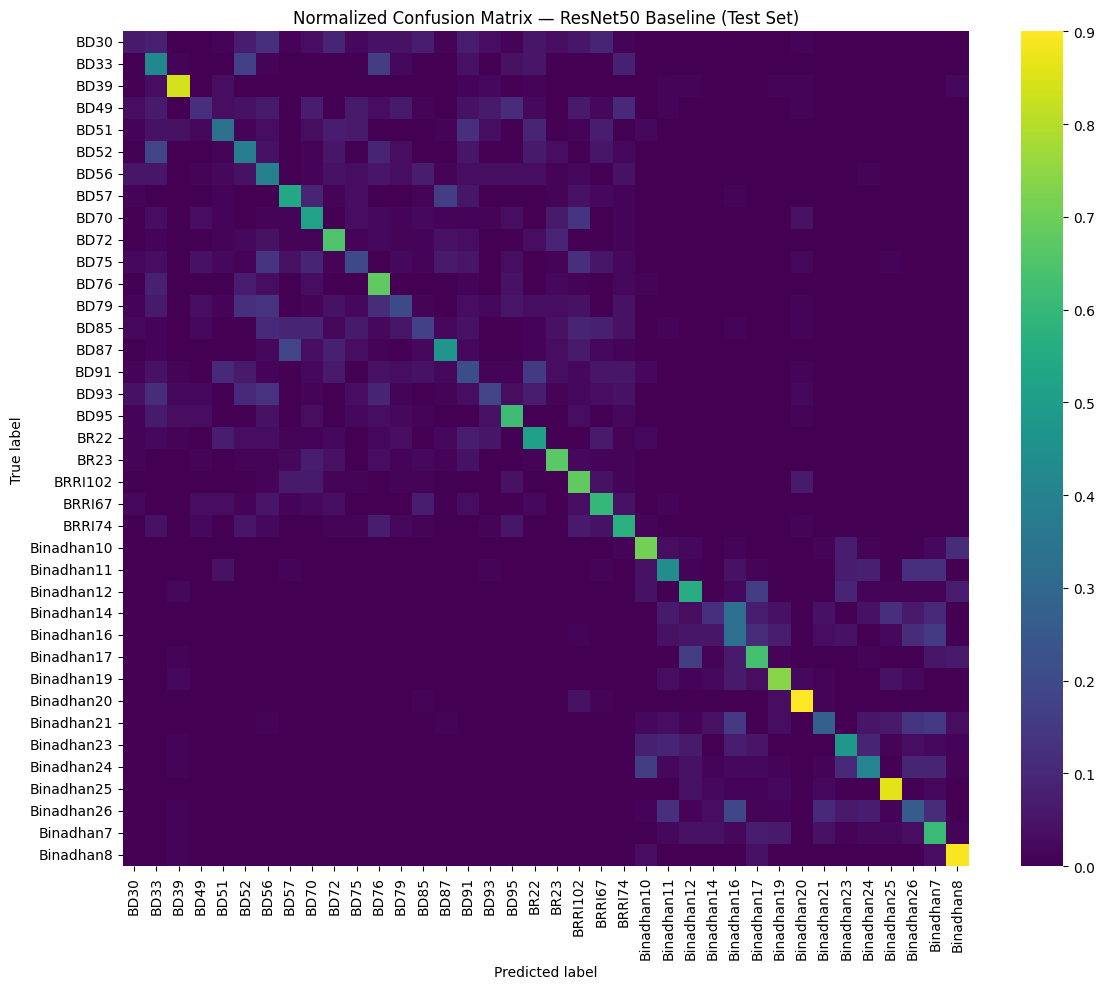

In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))

# Normalize per true class (row-wise)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm,
    cmap="viridis",
    xticklabels=classes,
    yticklabels=classes,
    cbar=True
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix — ResNet50 Baseline (Test Set)")
plt.tight_layout()
plt.show()


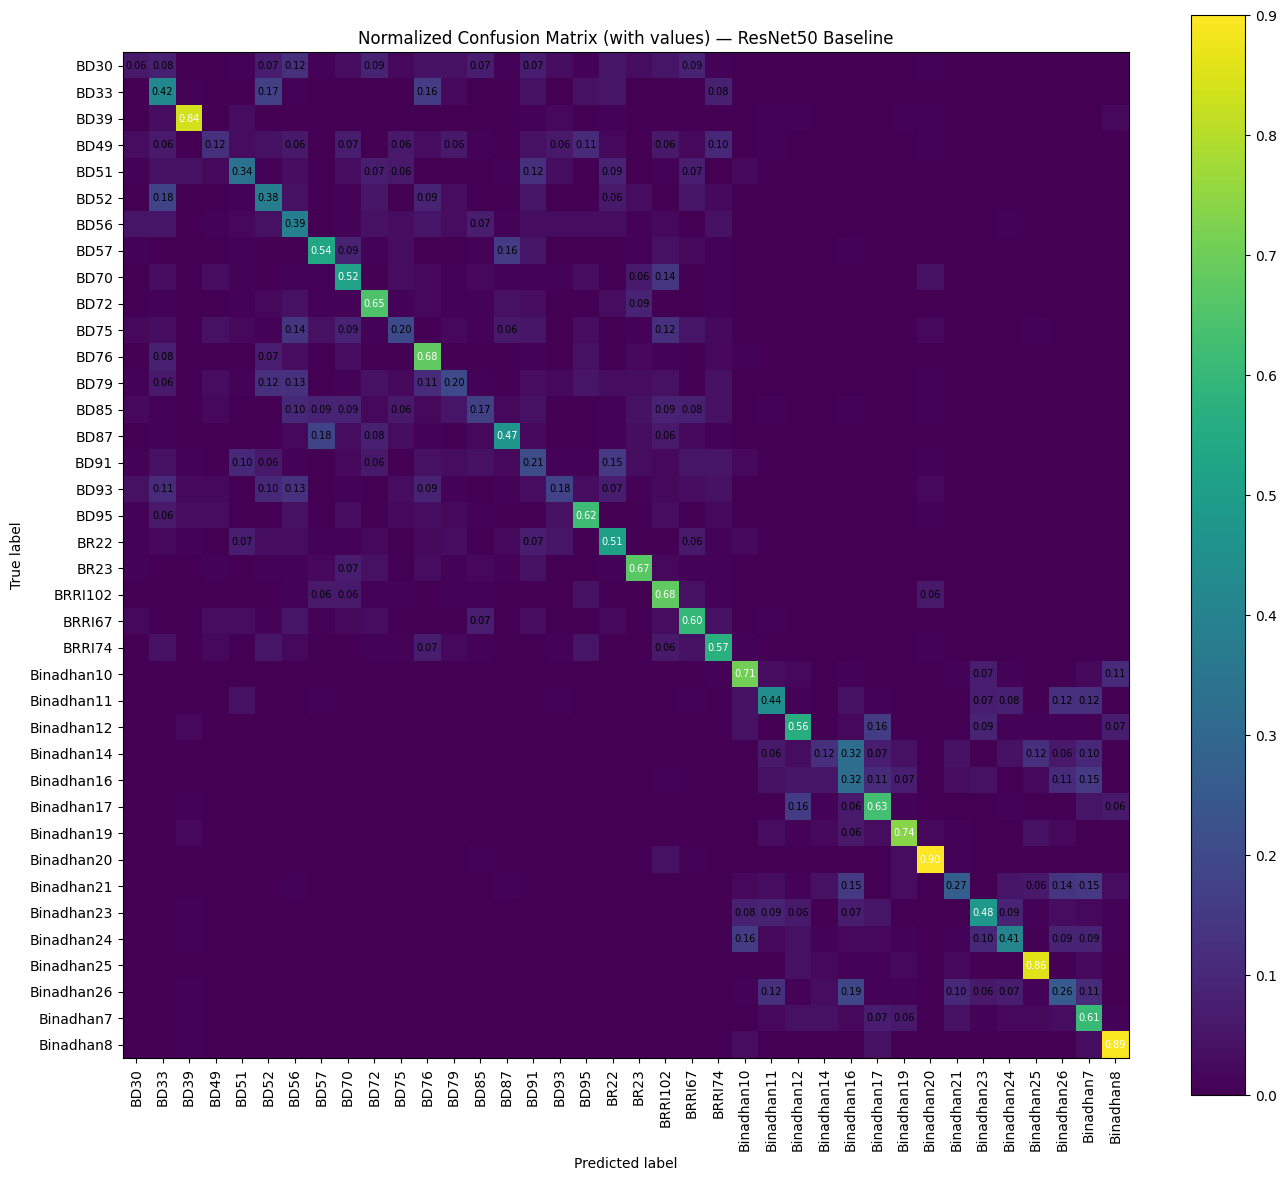

In [17]:
# Compute confusion matrix (already done before, but recompute cleanly)
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14, 12))
plt.imshow(cm_norm, interpolation="nearest", cmap="viridis")
plt.title("Normalized Confusion Matrix (with values) — ResNet50 Baseline")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

# Print numbers inside cells
thresh = cm_norm.max() / 2.0
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        value = cm_norm[i, j]
        if value > 0.05:  # avoid cluttering tiny values
            plt.text(
                j,
                i,
                f"{value:.2f}",
                horizontalalignment="center",
                verticalalignment="center",
                color="white" if value > thresh else "black",
                fontsize=7
            )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()


### Compute `Macro-F1` and `per-class F1`

In [19]:
# Macro-F1
macro_f1 = f1_score(y_true, y_pred, average="macro")
print("✅ Macro-F1:", macro_f1)

# Detailed per-class report
report = classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
)

print("\nClassification Report (per-class precision / recall / F1):\n")
print(report)

✅ Macro-F1: 0.46155582076267554

Classification Report (per-class precision / recall / F1):

              precision    recall  f1-score   support

        BD30     0.1935    0.0600    0.0916       100
        BD33     0.3088    0.4200    0.3559       100
        BD39     0.7925    0.8400    0.8155       100
        BD49     0.3158    0.1200    0.1739       100
        BD51     0.4595    0.3400    0.3908       100
        BD52     0.3193    0.3800    0.3470       100
        BD56     0.2727    0.3900    0.3210       100
        BD57     0.5455    0.5400    0.5427       100
        BD70     0.4194    0.5200    0.4643       100
        BD72     0.5285    0.6500    0.5830       100
        BD75     0.3226    0.2000    0.2469       100
        BD76     0.4503    0.6800    0.5418       100
        BD79     0.3333    0.2000    0.2500       100
        BD85     0.2982    0.1700    0.2166       100
        BD87     0.5465    0.4700    0.5054       100
        BD91     0.2143    0.2100    0.212